# PUBG Finish Placement Prediction

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("train.csv")

In [3]:
df_test = pd.read_csv("test.csv")

In [4]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (4357336, 26)
Test shape: (1867913, 25)


# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [7]:
df_train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [62]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357336 entries, 0 to 4357335
Data columns (total 26 columns):
Id                 int64
groupId            int64
matchId            int64
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
maxPlace           int64
numGroups          int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(20)
memory usage: 864.3 MB


# Columns Description

- groupId : Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- matchId : Integer ID to identify match. There are no matches that are in both the training and testing set.
- assists : Number of enemy players this player damaged that were killed by teammates.
- boosts : Number of boost items used.
- damageDealt : Total damage dealt. Note: Self inflicted damage is subtracted.
- DBNOs : Number of enemy players knocked.
- headshotKills : Number of enemy players killed with headshots.
- heals : Number of healing items used.
- killPlace : Ranking in match of number of enemy players killed.
- killPoints : Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
- kills : Number of enemy players killed.
- killStreaks : Max number of enemy players killed in a short amount of time.
- longestKill : Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- maxPlace : Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- numGroups : Number of groups we have data for in the match.
- revives : Number of times this player revived teammates.
- rideDistance : Total distance traveled in vehicles measured in meters.
- roadKills : Number of kills while in a vehicle.
- swimDistance : Total distance traveled by swimming measured in meters.
- teamKills : Number of times this player killed a teammate.
- vehicleDestroys : Number of vehicles destroyed.
- walkDistance : Total distance traveled on foot measured in meters.
- weaponsAcquired : Number of weapons picked up.
- winPoints : Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- winPlacePerc : The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to -last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [63]:
df_train.describe()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,...,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06,4.357336e+06
mean,3.102678e+06,1.024777e+06,2.385539e+04,2.656320e-01,9.636856e-01,1.329033e+02,6.901455e-01,2.385866e-01,1.187169e+00,4.703440e+01,...,1.649345e-01,4.238835e+02,2.557985e-03,4.136261e+00,1.388555e-02,5.146264e-03,1.055122e+03,3.457289e+00,1.500504e+03,4.718663e-01
std,1.797477e+06,6.967197e+05,1.378227e+04,6.342160e-01,1.560643e+00,1.699439e+02,1.191514e+00,6.103033e-01,2.366389e+00,2.732772e+01,...,4.672004e-01,1.222927e+03,6.346679e-02,2.757015e+01,1.329266e-01,7.425362e-02,1.116122e+03,2.402109e+00,4.253571e+01,3.079147e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.500000e+02,0.000000e+00
25%,1.537746e+06,4.741378e+05,1.191400e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.334000e+02,2.000000e+00,1.491000e+03,1.979000e-01
50%,3.110606e+06,9.430320e+05,2.383700e+04,0.000000e+00,0.000000e+00,8.776000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.732000e+02,3.000000e+00,1.500000e+03,4.583000e-01
75%,4.657295e+06,1.418544e+06,3.580100e+04,0.000000e+00,1.000000e+00,1.884000e+02,1.000000e+00,0.000000e+00,1.000000e+00,7.000000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.808000e+03,5.000000e+00,1.510000e+03,7.407000e-01
max,6.224522e+06,2.700605e+06,4.773300e+04,2.000000e+01,1.800000e+01,6.384000e+03,6.300000e+01,2.600000e+01,5.900000e+01,1.000000e+02,...,4.100000e+01,4.839000e+04,4.200000e+01,5.286000e+03,6.000000e+00,5.000000e+00,1.730000e+04,7.600000e+01,1.923000e+03,1.000000e+00


In [64]:
df_test.describe()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
count,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,...,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06,1.867913e+06
mean,3.135825e+06,2.110564e+06,5.796715e+04,2.650091e-01,9.636584e-01,1.327903e+02,6.892307e-01,2.379763e-01,1.186962e+00,4.704934e+01,...,4.070541e+01,1.654526e-01,4.253442e+02,2.555258e-03,4.286099e+00,1.383576e-02,5.192961e-03,1.056860e+03,3.454234e+00,1.500578e+03
std,1.795922e+06,2.605617e+05,5.902846e+03,6.334510e-01,1.560459e+00,1.693359e+02,1.188037e+00,6.082439e-01,2.364642e+00,2.733873e+01,...,2.216242e+01,4.679887e-01,1.226586e+03,5.956263e-02,2.877678e+01,1.325180e-01,7.496653e-02,1.118049e+03,2.379747e+00,4.225398e+01
min,4.773400e+04,1.659448e+06,4.773400e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.500000e+02
25%,1.560737e+06,1.884266e+06,5.286400e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,...,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.332000e+02,2.000000e+00,1.491000e+03
50%,3.154746e+06,2.111455e+06,5.796300e+04,0.000000e+00,0.000000e+00,8.775000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,...,2.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.746000e+02,3.000000e+00,1.500000e+03
75%,4.688376e+06,2.335570e+06,6.308200e+04,0.000000e+00,1.000000e+00,1.887000e+02,1.000000e+00,0.000000e+00,1.000000e+00,7.000000e+01,...,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.808000e+03,5.000000e+00,1.510000e+03
max,6.225248e+06,2.560534e+06,6.819100e+04,1.800000e+01,1.800000e+01,4.522000e+03,3.800000e+01,2.100000e+01,6.900000e+01,1.000000e+02,...,1.000000e+02,3.000000e+01,2.766000e+04,8.000000e+00,8.122000e+03,5.000000e+00,5.000000e+00,1.261000e+04,7.900000e+01,1.971000e+03


In [10]:
df_train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
maxPlace           0
numGroups          0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [12]:
df_test.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
maxPlace           0
numGroups          0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

# EDA

In [14]:
%matplotlib inline

## kills

In [65]:
print("Average kills {:.4f} players, \n98% of people have {} kills or less, \nMost kills recorded is {}.".format(df_train['kills'].mean(), df_train['kills'].quantile(0.99),
      df_train['kills'].max()))

Average kills 0.9345 players, 
98% of people have 7.0 kills or less, 
Most kills recorded is 60.


In [66]:
co_train = df_train.copy()

In [67]:
co_train.loc[co_train['kills']> co_train['kills'].quantile(0.99)]= '8+'

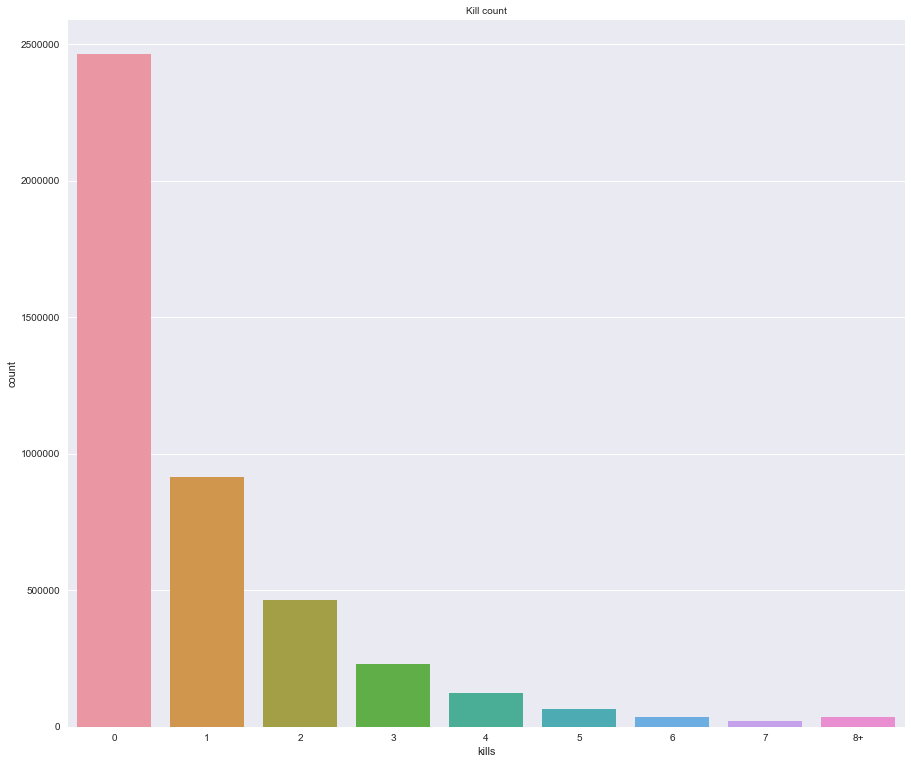

In [68]:
plt.figure(figsize=(15,13))
sns.countplot(co_train['kills'].astype('str').sort_values())
plt.title("Kill count", fontsize=10)
plt.show()

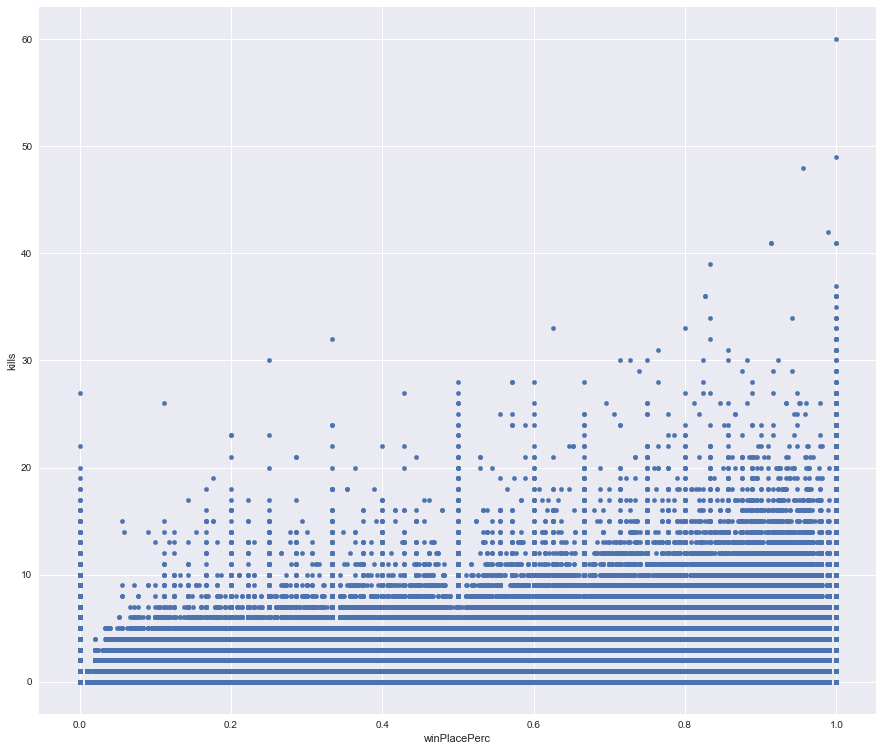

In [73]:
df_train.plot(x="winPlacePerc", y="kills", kind='scatter', figsize=(15,13))
plt.show()

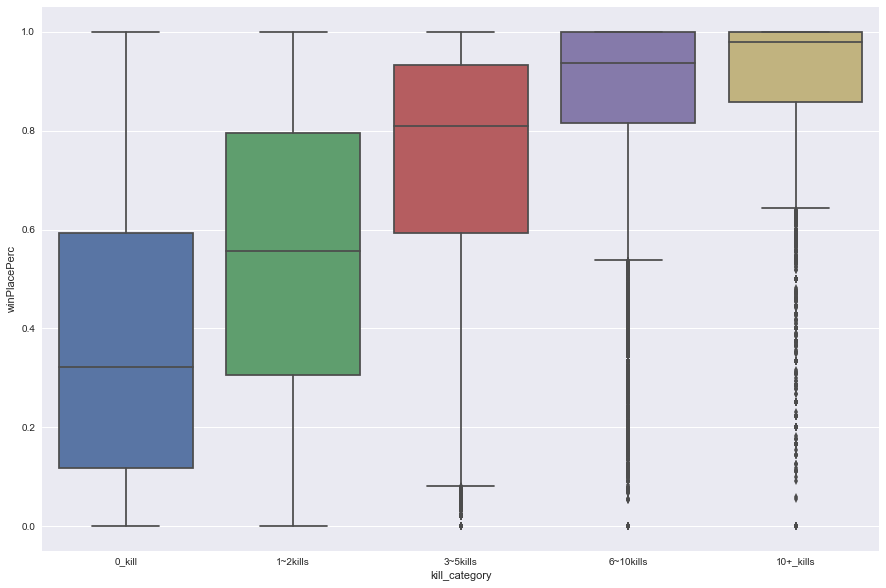

In [75]:
co_train = df_train.copy()

co_train['kill_category'] = pd.cut(co_train['kills'], [-1,0,2,5,10,60], labels=[
    '0_kill', '1~2kills', '3~5kills', '6~10kills', '10+_kills'
])

plt.figure(figsize=(15,10))
sns.boxplot(x='kill_category', y='winPlacePerc', data=co_train)
plt.show()

In [76]:
# more kill -> high winPlacePerc

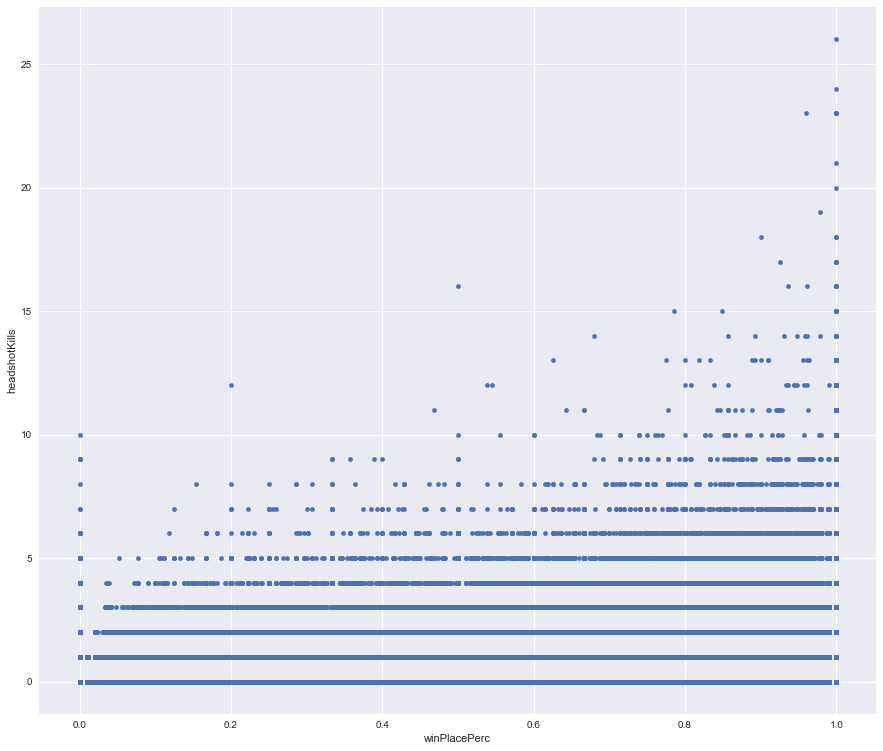

In [43]:
df_train.plot(x="winPlacePerc", y="headshotKills", kind='scatter', figsize=(15,13))
plt.show()

## Distance

In [77]:
print("players drive average distance {:.4f}m, \n98% of people have {} drive or less, \nLongest drive distance recorded is {}.".format(df_train['rideDistance'].mean(), df_train['rideDistance'].quantile(0.99),
      df_train['rideDistance'].max()))

players drive average distance 423.8835m, 
98% of people have 6133.0 drive or less, 
Longest drive distance recorded is 48390.0.


In [78]:
# size of map = 8km x 8km

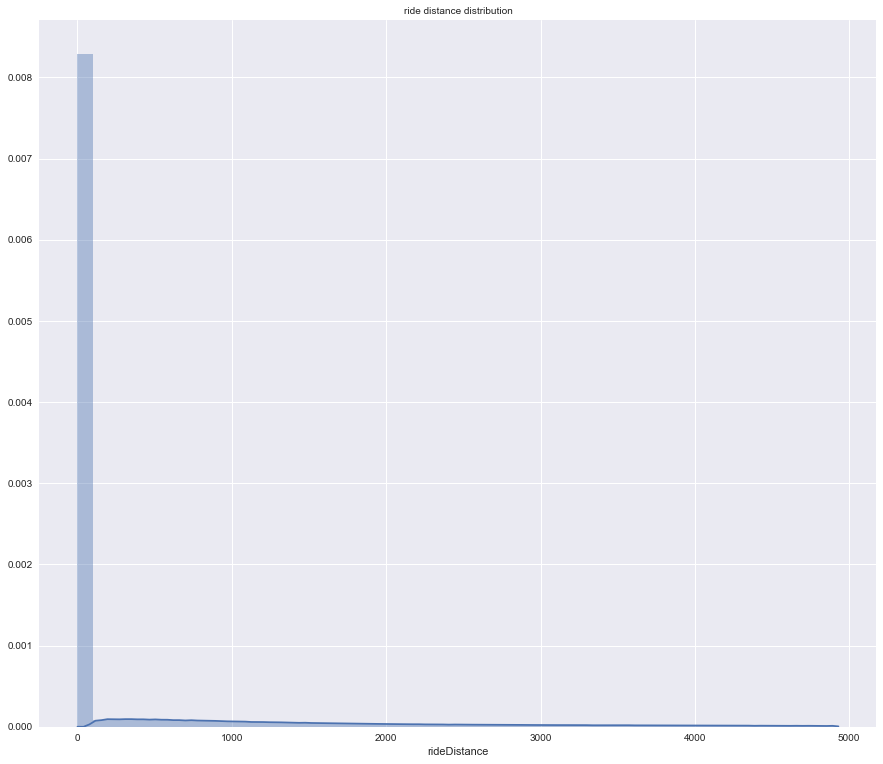

In [87]:
co_train = df_train.copy()
co_train = co_train[co_train['rideDistance']< co_train['rideDistance'].quantile(0.98)]
plt.figure(figsize=(15,13))
plt.title('ride distance distribution', fontsize=10)
sns.distplot(co_train['rideDistance'])
plt.show()

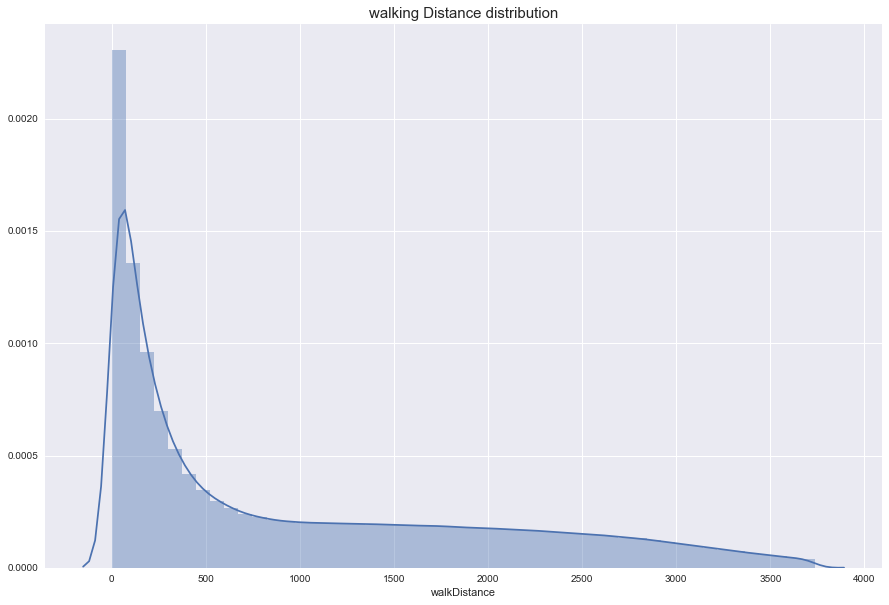

In [100]:
co_train = df_train.copy()
co_train = co_train[co_train['walkDistance'] < co_train['walkDistance'].quantile(0.98)]
plt.figure(figsize=(15,10))
plt.title("walking Distance distribution",fontsize=15)
sns.distplot(co_train['walkDistance'])
plt.show()

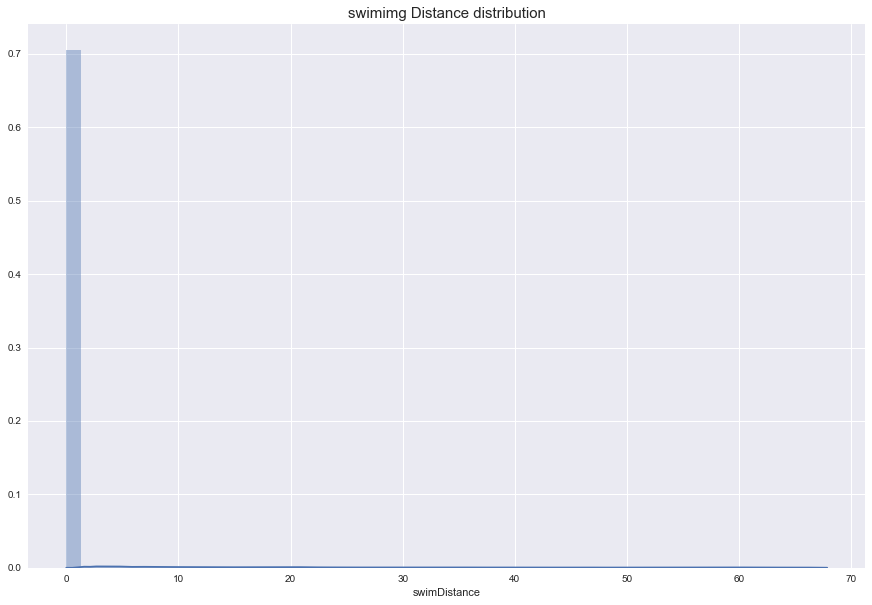

In [101]:
co_train = df_train.copy()
co_train = co_train[co_train['swimDistance'] < co_train['swimDistance'].quantile(0.98)]
plt.figure(figsize=(15,10))
plt.title("swimimg Distance distribution",fontsize=15)
sns.distplot(co_train['swimDistance'])
plt.show()

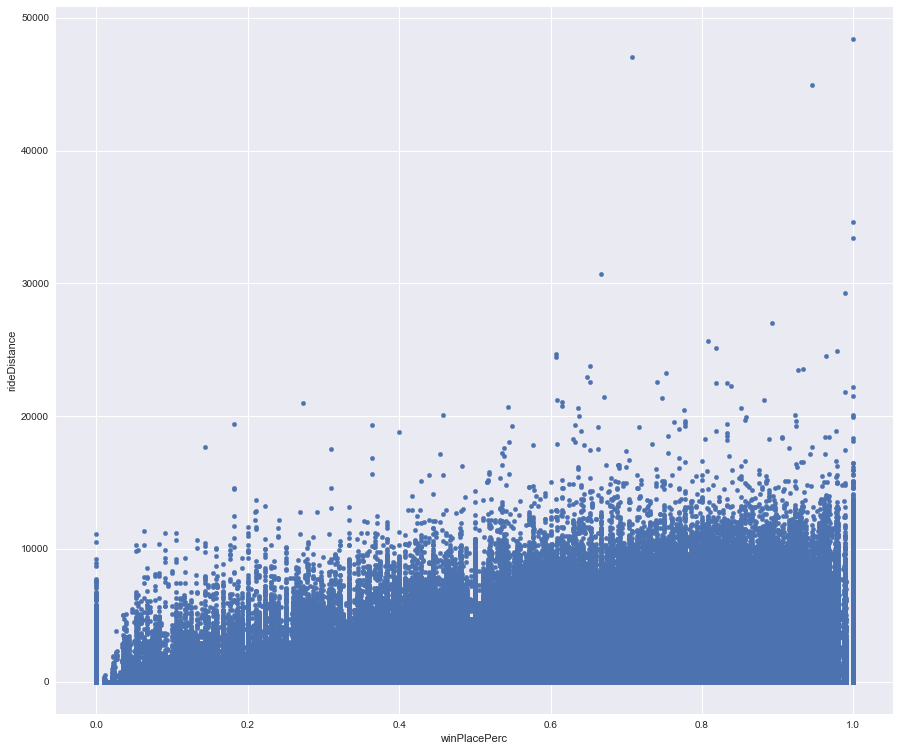

In [102]:
df_train.plot(x="winPlacePerc", y="rideDistance", kind='scatter', figsize=(15,13))
plt.show()

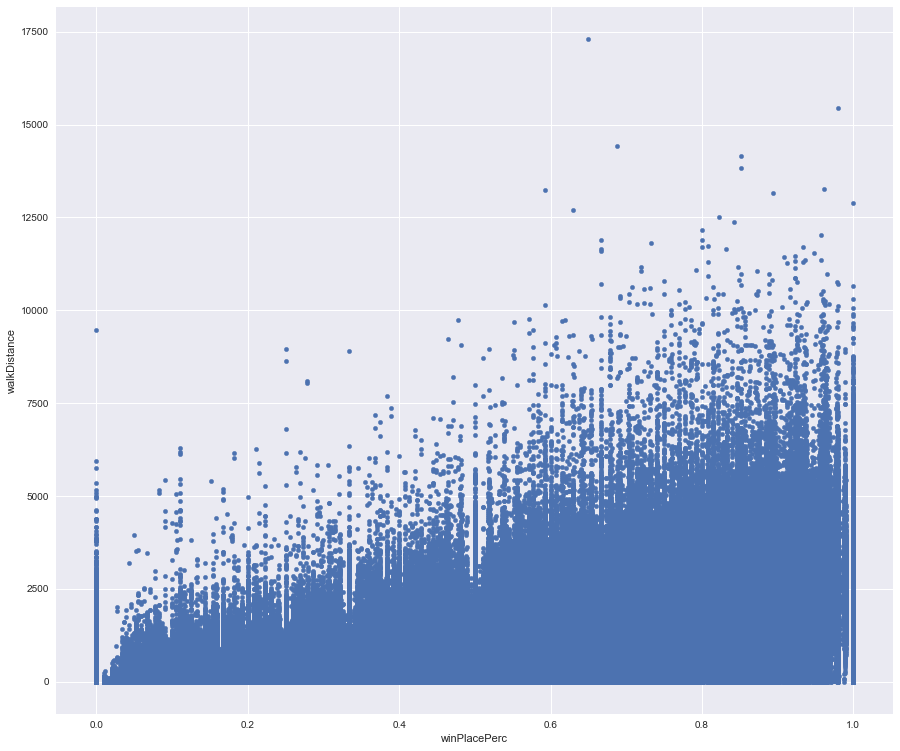

In [103]:
df_train.plot(x="winPlacePerc", y="walkDistance", kind='scatter', figsize=(15,13))
plt.show()

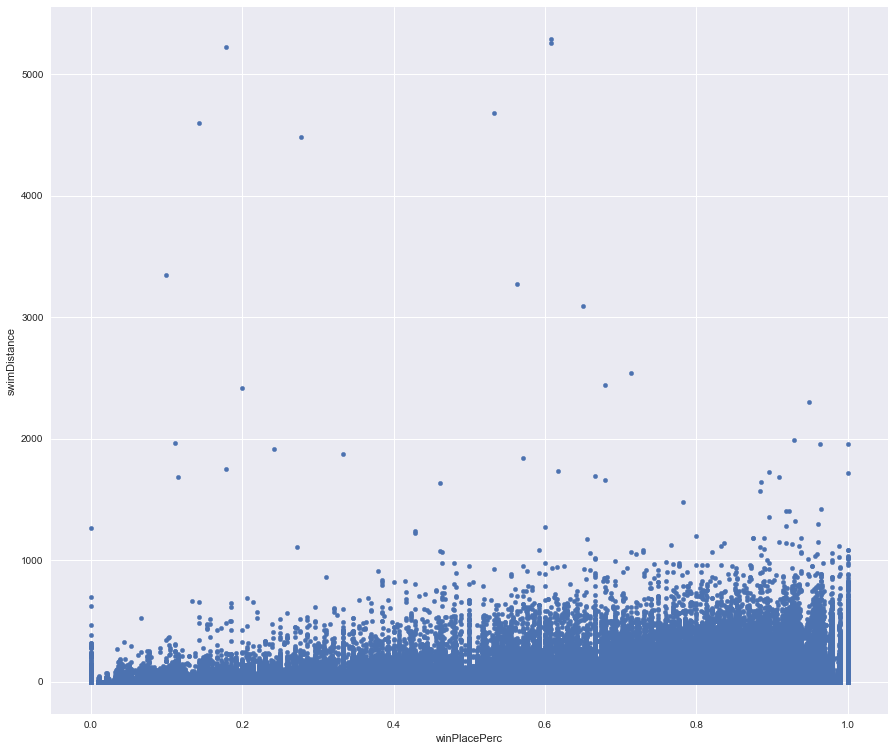

In [104]:
df_train.plot(x="winPlacePerc", y="swimDistance", kind='scatter', figsize=(15,13))
plt.show()

In [94]:
print("Average person walks for {:.1f}m, \n98% of people have walked {}m or less, \nwhile the player who walked max distance {}m.".format(co_train['walkDistance'].mean(), co_train['walkDistance'].quantile(0.98), co_train['walkDistance'].max()))

Average person walks for 1034.6m, 
98% of people have walked 3731.0m or less, 
while the player who walked max distance 15440.0m.


In [95]:
print("Average person drived for {:.1f}m, \n98% of people have drived {}m or less, \nwhile the player who drived max distance {}m.".format(co_train['rideDistance'].mean(), co_train['rideDistance'].quantile(0.98), co_train['rideDistance'].max()))

Average person drived for 298.2m, 
98% of people have drived 3553.0m or less, 
while the player who drived max distance 4930.0m.


In [97]:
print("Average person swam for {:.1f}m, \n98% of people have swam {}m or less, \nwhile the player who swam max distance {}m.".format(co_train['swimDistance'].mean(), co_train['swimDistance'].quantile(0.98), co_train['swimDistance'].max()))

Average person swam for 4.1m, 
98% of people have swam 67.45m or less, 
while the player who swam max distance 5286.0m.


In [98]:
print("{} players ({:.4f}%) drived for 0 meters. \nThis means that they walked around.".format(len(co_train[co_train['rideDistance'] == 0]), 100*len(co_train[co_train['rideDistance']==0])/len(df_train)))

3439985 players (78.9470%) drived for 0 meters. 
This means that they walked around.


# Item(heals & boost)

In [12]:
print("Average players use {:.1f} heal items, \n98% of people use {} or less, \nwhile the player who use heal item max used {}.".format(df_train['heals'].mean(), df_train['heals'].quantile(0.98), df_train['heals'].max()))
print("\n")
print("Average payers use {:.1f} boost items, \n98% of people use {} or less, \nwhile the player who use boost item max used {}.".format(df_train['boosts'].mean(), df_train['boosts'].quantile(0.98), df_train['boosts'].max()))

Average players use 1.2 heal items, 
98% of people use 9.0 or less, 
while the player who use heal item max used 59.


Average payers use 1.0 boost items, 
98% of people use 6.0 or less, 
while the player who use boost item max used 18.


In [13]:
co_train = df_train.copy()
co_train = co_train[co_train['heals'] < co_train['heals'].quantile(0.98)]
co_train = co_train[co_train['boosts'] < co_train['boosts'].quantile(0.98)]

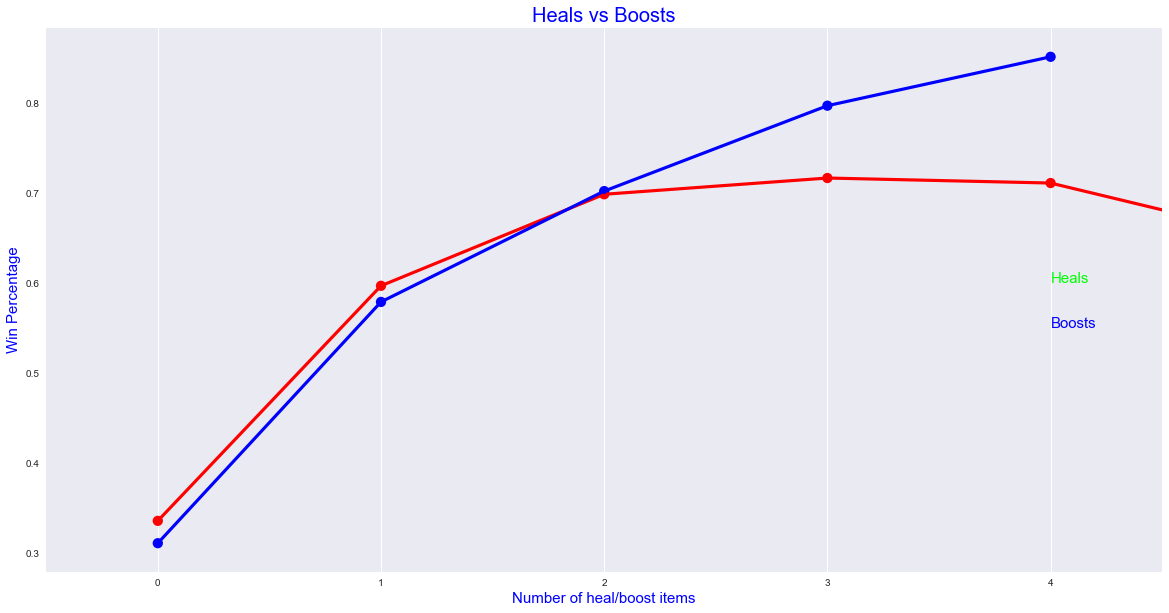

In [16]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=co_train,color='red',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=co_train,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 15)
plt.text(4,0.55,'Boosts',color='blue',fontsize = 15)
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

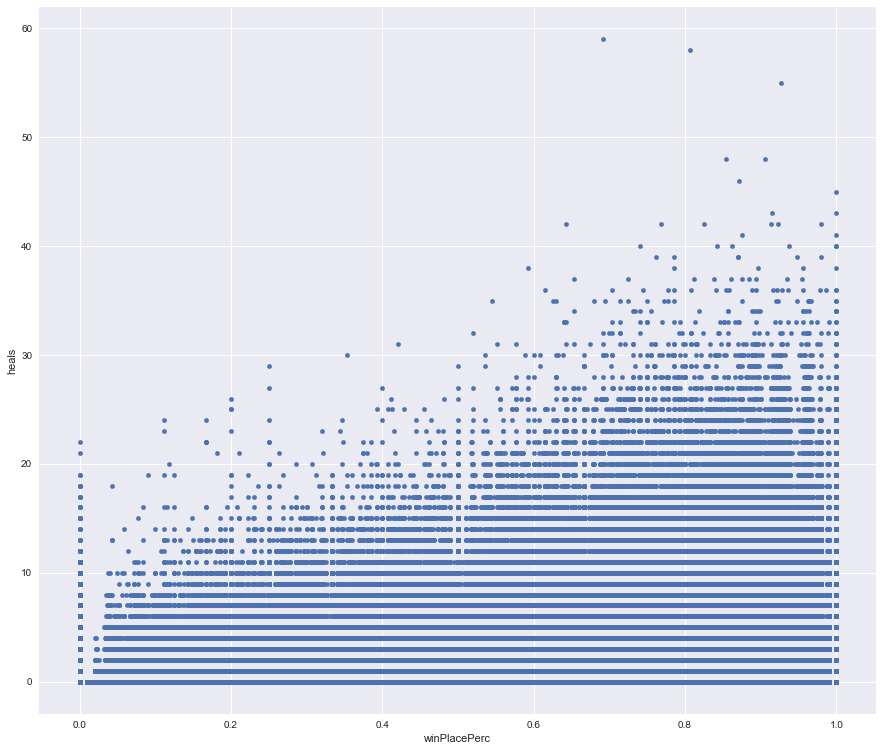

In [18]:
df_train.plot(x="winPlacePerc", y="heals", kind='scatter', figsize=(15,13))
plt.show()

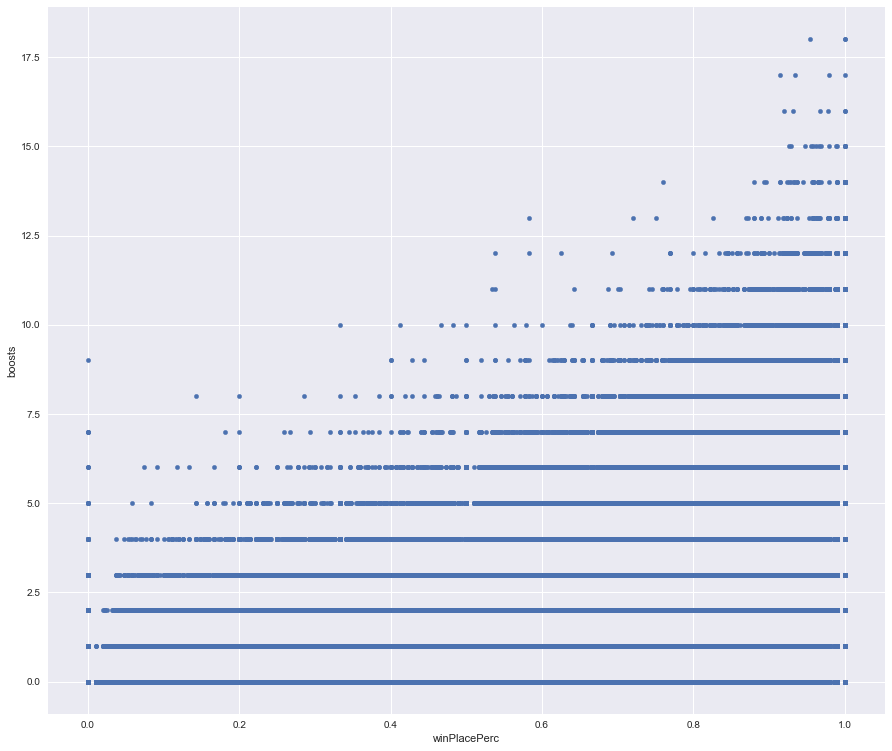

In [19]:
df_train.plot(x="winPlacePerc", y="boosts", kind='scatter', figsize=(15,13))
plt.show()

# Solo, Duo, Squad
- 3 game modes in the game.
- solo : play solo
- duo : play with a friend
- squad : play with 3 other friends

### duo -> 50 max teams
### squad -> 25 max teams

In [20]:
solo = df_train[df_train['numGroups']>50]
duo = df_train[(df_train['numGroups']>25) & (df_train['numGroups']<=50)]
squad = df_train[df_train['numGroups']<=25]

In [32]:
print("Game ratio \n{} ({:.2f}%) solo games,\n{} ({:.2f}%) duo games,\n{} ({:.2f}%) squad games.".format(len(solo), 100*len(solo)/len(df_train), len(duo), 100*len(duo)/len(df_train), len(squad), 100*len(squad)/len(df_train),))

Game ratio 
563279 (12.93%) solo games,
3070150 (70.46%) duo games,
723907 (16.61%) squad games.


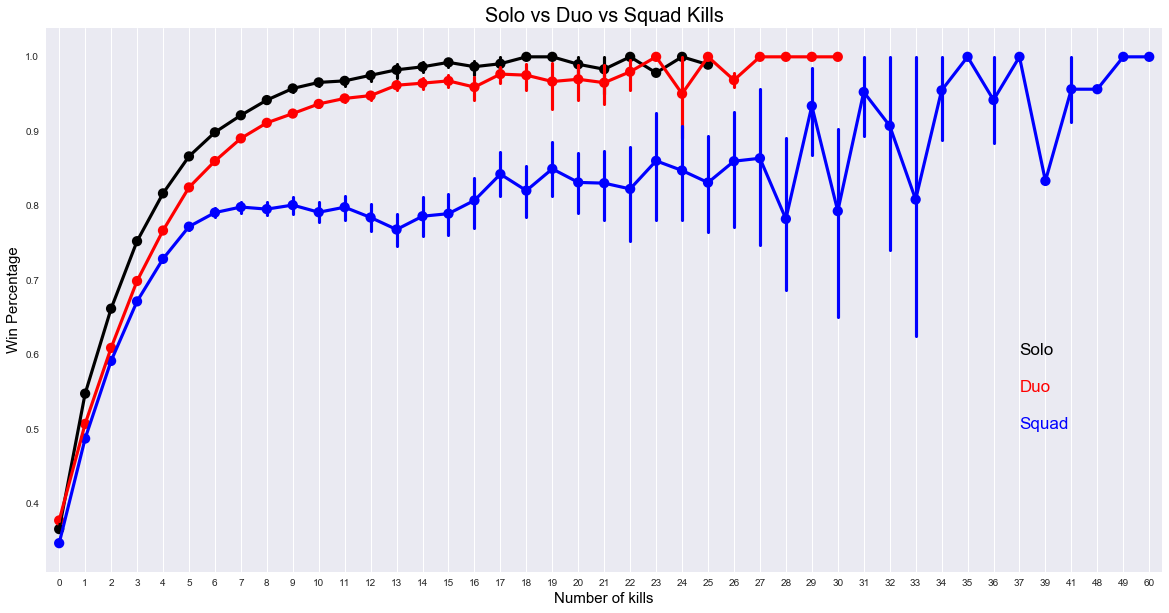

In [34]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solo,color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duo,color='red',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squad,color='blue',alpha=0.8)
plt.text(37,0.6,'Solo',color='black',fontsize = 17)
plt.text(37,0.55,'Duo',color='red',fontsize = 17)
plt.text(37,0.5,'Squad',color='blue',fontsize = 17)
plt.xlabel('Number of kills',fontsize = 15,color='black')
plt.ylabel('Win Percentage',fontsize = 15,color='black')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='black')
plt.grid()
plt.show()

In [35]:
# playing solo and duo seems kills matter.
# playing squad seems kills don't matter

# DBNOs & assists & revives & teamkills

In [36]:
## column name DBNOs means player knocked. "knock" happen in duo & squad.
## column name assist means an involvement in a kill. "assist" happen in duo & squad.
## column name revive means knocked player revived by teammate. "revive' happen in duo & squad.

In [37]:
solo = df_train[df_train['numGroups']>50]
duo = df_train[(df_train['numGroups']>25) & (df_train['numGroups']<=50)]
squad = df_train[df_train['numGroups']<=25]

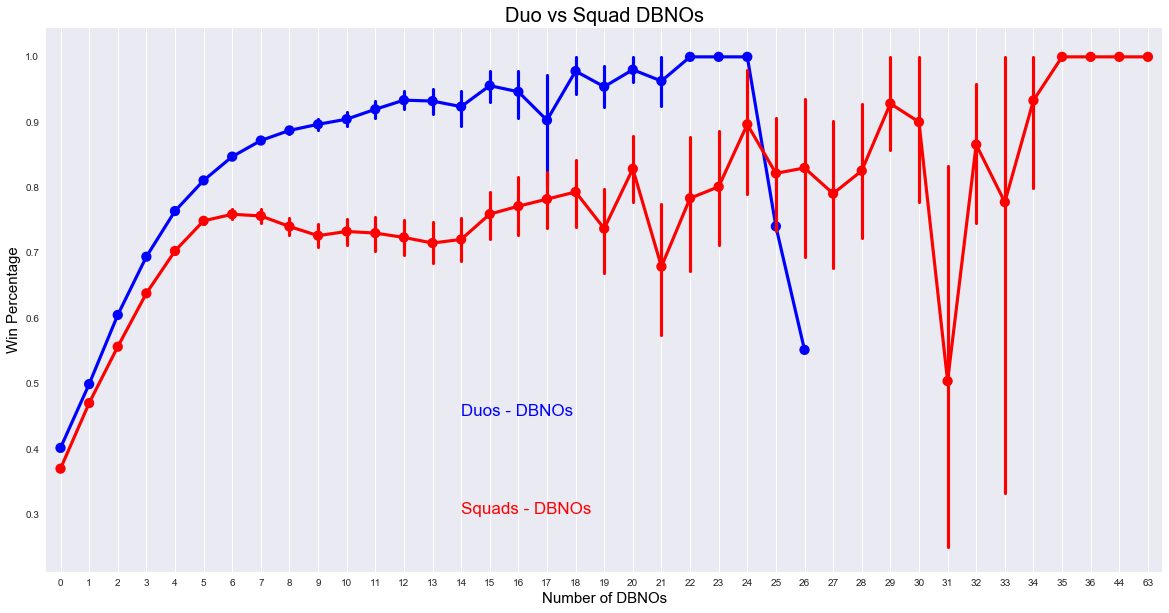

In [39]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duo,color='blue',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squad,color='red',alpha=0.8)
plt.text(14,0.45,'Duos - DBNOs',color='blue', fontsize = 17)
plt.text(14,0.3,'Squads - DBNOs',color='red',fontsize = 17)
plt.xlabel('Number of DBNOs',fontsize = 15,color='black')
plt.ylabel('Win Percentage',fontsize = 15,color='black')
plt.title('Duo vs Squad DBNOs',fontsize = 20,color='black')
plt.grid()
plt.show()

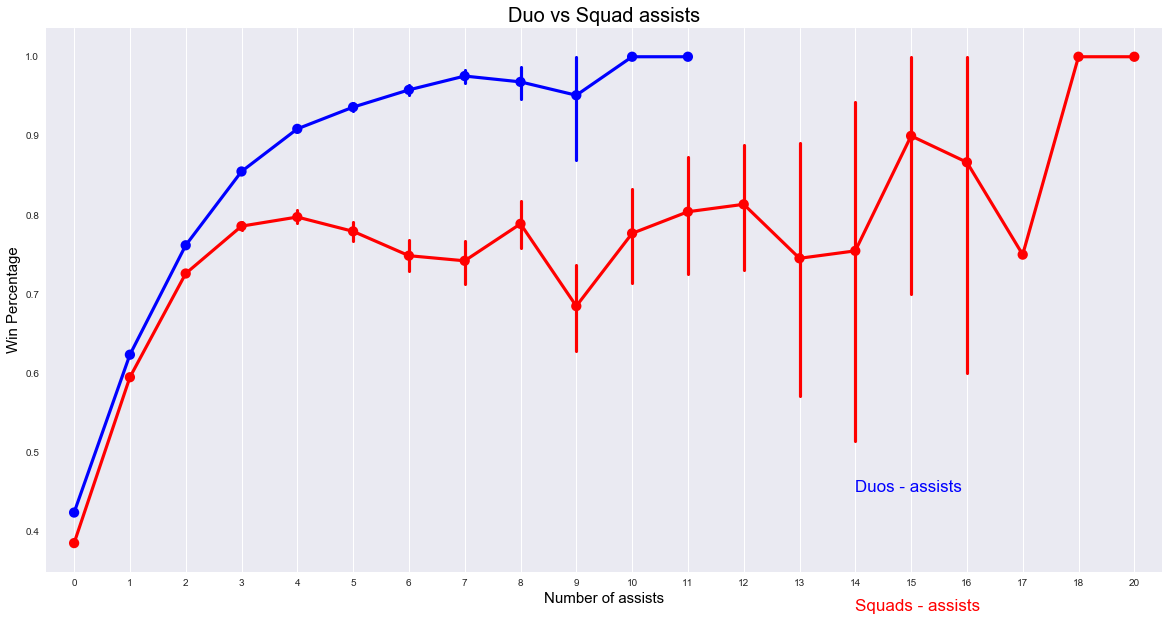

In [40]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='assists',y='winPlacePerc',data=duo,color='blue',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squad,color='red',alpha=0.8)
plt.text(14,0.45,'Duos - assists',color='blue',fontsize = 17)
plt.text(14,0.3,'Squads - assists',color='red',fontsize = 17)
plt.xlabel('Number of assists',fontsize = 15,color='black')
plt.ylabel('Win Percentage',fontsize = 15,color='black')
plt.title('Duo vs Squad assists',fontsize = 20,color='black')
plt.grid()
plt.show()

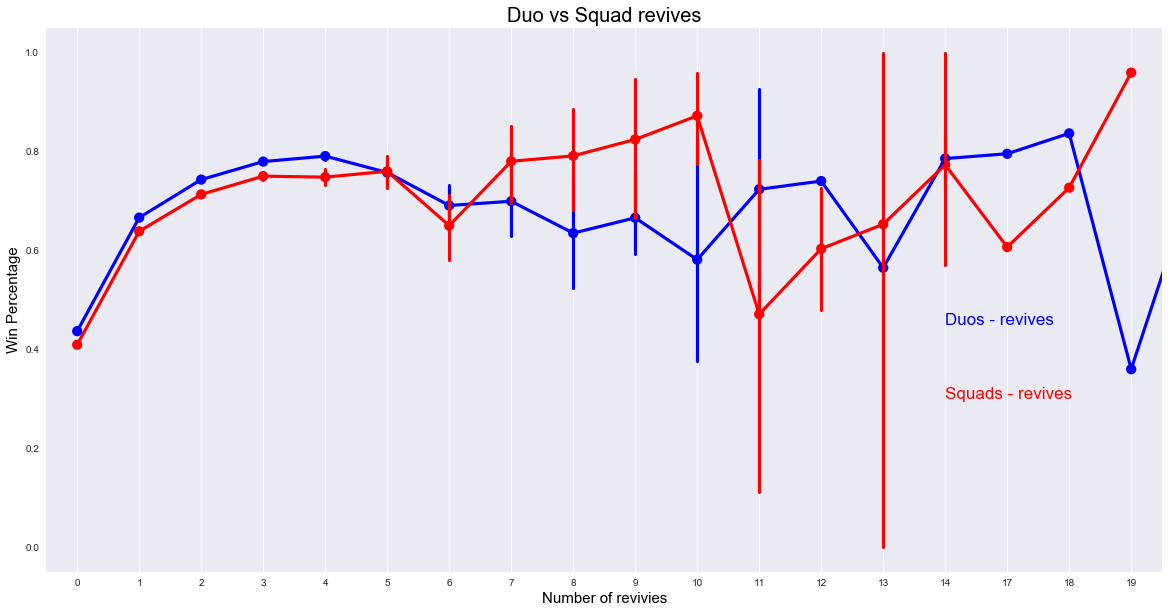

In [41]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='revives',y='winPlacePerc',data=duo,color='blue',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squad,color='red',alpha=0.8)
plt.text(14,0.45,'Duos - revives',color='blue',fontsize = 17)
plt.text(14,0.3,'Squads - revives',color='red',fontsize = 17)
plt.xlabel('Number of revivies',fontsize = 15,color='black')
plt.ylabel('Win Percentage',fontsize = 15,color='black')
plt.title('Duo vs Squad revives',fontsize = 20,color='black')
plt.grid()
plt.show()

## weapons Acquired

In [46]:
print("Average number of acquired weapons is {:.4f},\nminimum is {} and the maximum {},\n98% of players acquired less than weapons {}." 
      .format(df_train["weaponsAcquired"].mean(), df_train["weaponsAcquired"].min(), df_train["weaponsAcquired"].max(), df_train["weaponsAcquired"].quantile(0.98)))

Average number of acquired weapons is 3.4573,
minimum is 0 and the maximum 76,
98% of players acquired less than weapons 9.0.


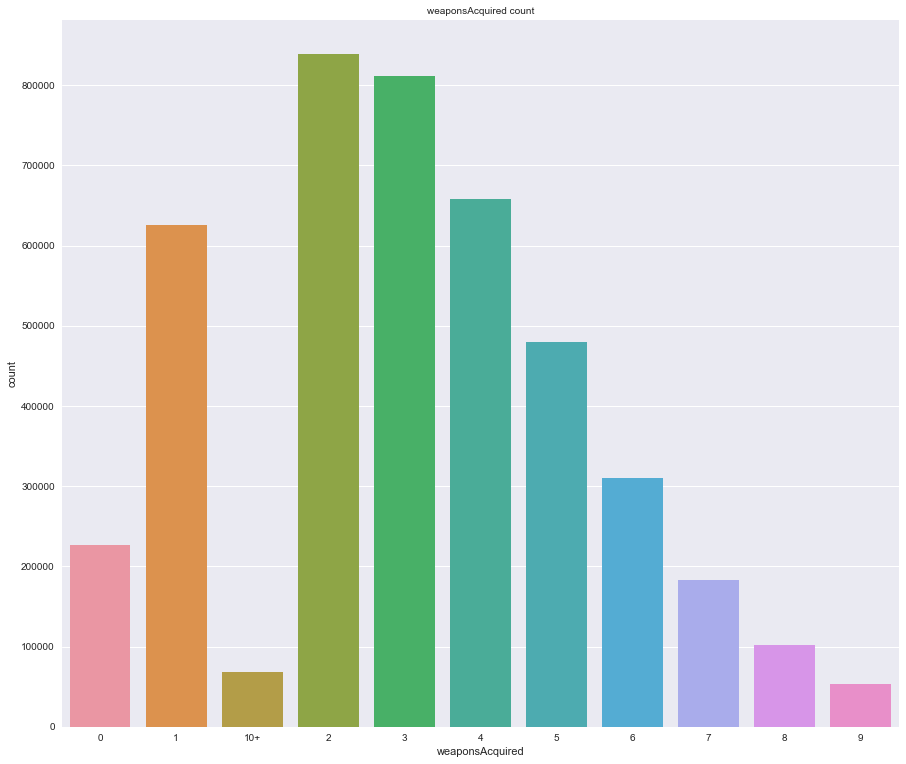

In [49]:
co_train = df_train.copy()
co_train.loc[co_train['weaponsAcquired']> co_train['weaponsAcquired'].quantile(0.98)]= '10+'
plt.figure(figsize=(15,13))
sns.countplot(co_train['weaponsAcquired'].astype('str').sort_values())
plt.title("weaponsAcquired count", fontsize=10)
plt.show()

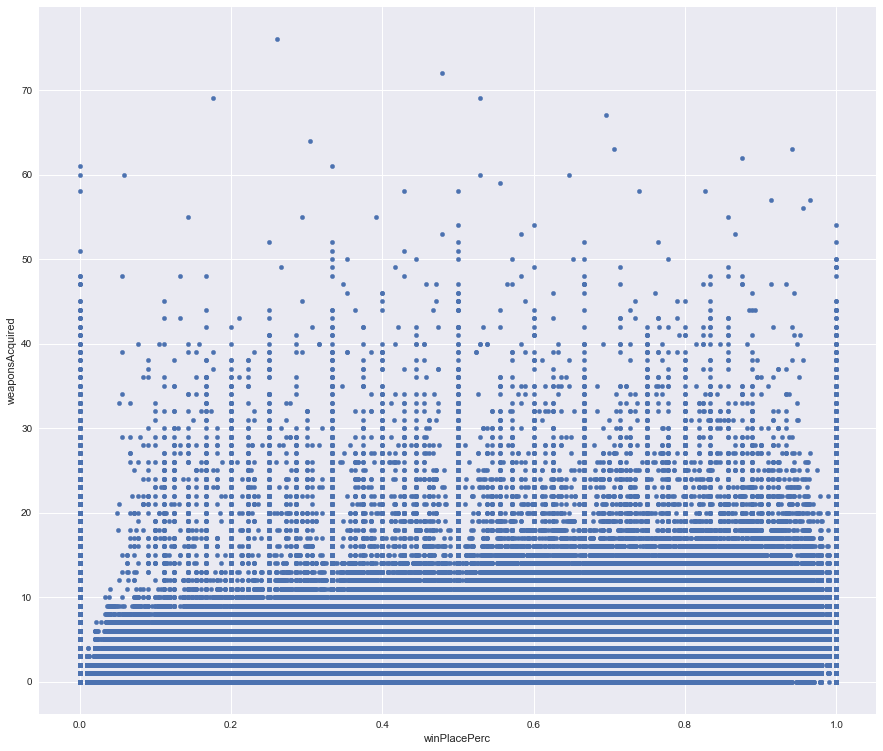

In [48]:
df_train.plot(x="winPlacePerc", y="weaponsAcquired", kind='scatter', figsize=(15,13))
plt.show()

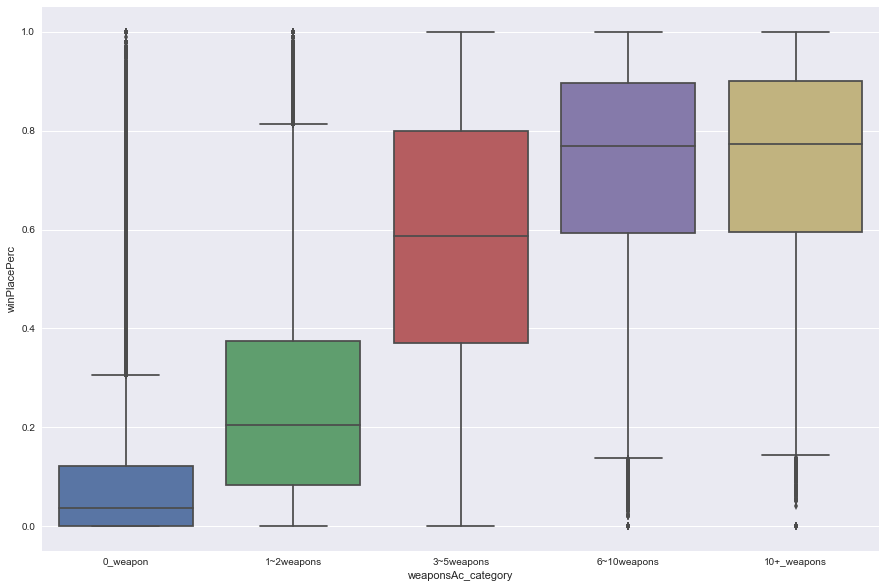

In [53]:
co_train = df_train.copy()

co_train['weaponsAc_category'] = pd.cut(co_train['weaponsAcquired'], [-1,0,2,5,10,76], labels=[
    '0_weapon', '1~2weapons', '3~5weapons', '6~10weapons', '10+_weapons'
])

plt.figure(figsize=(15,10))
sns.boxplot(x='weaponsAc_category', y='winPlacePerc', data=co_train)
plt.show()

## vehicleDestroys